# 1. Set up the notebook

Import modules.

In [1]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d
from IPython.display import display, IFrame, HTML

Define a function to load data from a hardware flight test and resample it at 100 Hz using linear interpolation.

In [2]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0, only_in_flight=False):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
    
    # truncate to times when o_z_des is positive
    if only_in_flight:
        i = []
        for k in ['ae483log.o_z_des', 'ctrltarget.z']:
            if k in resampled_data.keys():
                j = np.argwhere(resampled_data[k] > 0).flatten()
                if len(j) > len(i):
                    i = j
        if len(i) < 2:
            raise Exception(
                'Failed to get "only_in_flight" data.\n' + \
                ' - Did you remember to log "ae483log.o_z_des" and was it ever positive?\n' + \
                ' - Did you remember to log "ctrltarget.z" and was it ever positive?\n'
            )
        for key in resampled_data.keys():
            resampled_data[key] = resampled_data[key][i[0]:i[-1]]
        
    # return the resampled data
    return resampled_data

Define a function to solve the linear quadratic regulator (LQR) problem - i.e., that finds the matrix $K$ for which

$$u(t) = - K x(t)$$

is the optimal solution to

$$
\begin{align*}
\underset{u_{[t_{0}, \infty)}}{\text{minimize}} &\qquad \int_{t_{0}}^{\infty}\left( x(t)^{T}Qx(t)+u(t)^{T}Ru(t)\right)dt \\
\text{subject to} &\qquad \dot{x}(t) = Ax(t)+Bu(t), \quad x(t_{0})=x_{0}.
\end{align*}
$$

In [3]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

Define a function to create the observability matrix

$$ W_o = \begin{bmatrix} C \\ CA \\ CA^2 \\ \vdots \\ CA^{n-1} \end{bmatrix} $$

where $A$ has size $n \times n$.

In [4]:
def obsv(A, C):
    W = C
    for i in range(1, A.shape[0]):
        W = np.vstack([W, C @ np.linalg.matrix_power(A, i)])
    return W

Define a function to embed videos that have been uploaded to [Illinois Mediaspace](https://mediaspace.illinois.edu/).

In [5]:
def mediaspace(url, width=640, height=397):
    video_id = url.rsplit('/', 1)[-1]
    src = f'https://mediaspace.illinois.edu/embed/secure/iframe/entryId/{video_id}?st=0'
    display(IFrame(src, width=width, height=height))
    display(HTML(f'<a href="{url}" target="_blank">Go to video on Illinois Mediaspace</a>'))

In [6]:
# Define symbolic variables
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define rotation about the body-fixed z axis by psi
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

# Define rotation about the body-fixed y axis by theta
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

# Define rotation about the body-fixed x axis by phi
Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

# Apply sequential transformation to compute the rotation
# matrix R_1in0 that describes the orientation of the drone
# (i.e., of frame 1 in the coordinates of frame 0)
R_1in0 = Rz @ Ry @ Rx

# Create a function that returns R_1in0 as a numpy array
R_1in0 = sym.lambdify((psi, theta, phi), R_1in0)

# Delete variables that are no longer needed
del psi, theta, phi, Rz, Ry, Rx

# 2. Design observer

## 2.1 Define state-space model

Here are the matrices that describe the state-space model

$$\begin{align*} \dot{x} &= Ax + Bu \\ y &= Cx + Bu \end{align*}$$

that was derived in Lab 7 (copy/pasted from that week's analysis notebook).

In [7]:
# FIXME (copy/paste definition of A, B, C, D)
g = 9.81
A = np.array([[0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, g, 0, 0, 0, 0], [0, 0, 0, 0, 0, -g, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]])
B = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1]])
C = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0]])
D = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])


## 2.2 Show that not all states are observable

Find the observability matrix

$$ W_o = \begin{bmatrix} C \\ CA \\ CA^2 \\ \vdots \\ CA^{n-1} \end{bmatrix} $$

where $A$ is $n \times n$.

In [8]:
W_o = obsv(A, C)

Find the rank of the observability matrix using [numpy.linalg.matrix_rank](https://numpy.org/doc/stable/reference/generated/numpy.linalg.matrix_rank.html). The system is **observable** if and only if $W_o$ is **full rank**, that is, if its rank is equal to the number of states $n$.

In [9]:
print(f'      rank of W_o is: {np.linalg.matrix_rank(W_o)}')
print(f'"full rank" would be: {A.shape[0]}')

      rank of W_o is: 8
"full rank" would be: 9


If the system is *not* observable, then it is impossible to design a stable observer - that is, an observer that makes the error in your estimate of each state converge to zero over time.

In particular, the following code would produce an error if you tried to use it:
```python
# Choose weights
Q = np.eye(3) # <-- one diagonal entry for each output
R = np.eye(9) # <-- one diagonal entry for each state

# Find gain matrix
L = lqr(A.T, C.T, linalg.inv(R), linalg.inv(Q)).T
```
It does not matter what method you use - if it is impossible to design a stable observer, that's it, you're out of luck!

## 2.3 Choose a subset of states that are observable

List the index of each state to include.

In [10]:
# FIXME: delete the index of each state that is not observable!

s_obs_index = [
    0, # o_x
    1, # o_y
    2, # o_z
#     3, # psi
    4, # theta
    5, # phi
    6, # v_x
    7, # v_y
    8, # v_z
]

Define a state-space model

$$
\begin{align*}
\dot{x}_\text{obs} = A_\text{obs} x_\text{obs} + B_\text{obs} u \\
y = C_\text{obs} x_\text{obs} + D_\text{obs} u
\end{align*}
$$

with only these states.

In [11]:
A_obs = A[s_obs_index, :][:, s_obs_index]
B_obs = B[s_obs_index, :]
C_obs = C[:, s_obs_index]
D_obs = D

Show the matrices that describe this state-space model.

In [12]:
print(f'A_obs:\n{A_obs}\n')
print(f'B_obs:\n{B_obs}\n')
print(f'C_obs:\n{C_obs}\n')
print(f'D_obs:\n{D_obs}\n')

A_obs:
[[ 0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    9.81  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -9.81  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]

B_obs:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 1]]

C_obs:
[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]]

D_obs:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]



Check that this subsystem is observable:

In [13]:
print(f'      rank of W_o is: {np.linalg.matrix_rank(obsv(A_obs, C_obs))}')
print(f'"full rank" would be: {A_obs.shape[0]}')

      rank of W_o is: 8
"full rank" would be: 8


## 2.4 Choose gain matrix for the observable subsystem

### 2.4.2 With weights chosen by model error variance

Choose weights $Q$ and $R$ based on variance of model error.

In [14]:
# FIXME:
#
# (1) Change the size of each matrix to match the number of
#     states and outputs for your observable subsystem
#
# (2) Change the value of each diagonal entry based on your
#     results from Lab 7.

Q = np.diag([
    (1./0.003)**2,             # n_x
    (1./0.004)**2,             # n_y
    (1./0.002)**2,             # r
])

R = np.diag([
    (1/0.026)**2., # o_x
    (1/0.026)**2., # o_y
    (1/0.033)**2., # o_z
#   ( /0.)**2 1., # psi
    (1/0.103)**2., # theta
    (1/0.203)**2., # phi
    (1/0.149)**2., # v_x
    (1/0.115)**2., # v_y
    (1/0.187)**2., # v_z
])

L = lqr(A_obs.T, C_obs.T, linalg.inv(R), linalg.inv(Q)).T

L_str = np.array2string(L,
                        formatter={'float_kind': lambda x: f'{x:12.6f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'L = {L_str}')

L = [[   17.758182     0.000000     0.000000]
     [    0.000000    17.722312     0.000000]
     [    0.000000     0.000000    21.430119]
     [   34.333333     0.000000     0.000000]
     [    0.000000   -50.750000     0.000000]
     [  120.120957     0.000000     0.000000]
     [    0.000000   135.915174     0.000000]
     [    0.000000     0.000000    93.500000]]


# 3. Implement and test observer (offline)

In [15]:
data = load_hardware_data(
    'lab9_square_flight4.json',   # <-- 'lab9_square_flight1.json' flight with default observer
    t_min_offset=0.,
    t_max_offset=0.,
    only_in_flight=True,
)

# time
t = data['time']

## "true states" (obtained from default observer)
o_x_true = data['stateEstimate.x']
o_y_true = data['stateEstimate.y']
o_z_true = data['stateEstimate.z']
v_x_true = data['stateEstimate.vx']
v_y_true = data['stateEstimate.vy']
v_z_true = data['stateEstimate.vz']
# Note: stateEstimates are in degrees and the sign of pitch is reverse of AE483's convention
psi_true = np.deg2rad(data['stateEstimate.yaw']) 
theta_true = - np.deg2rad(data['stateEstimate.pitch'])
phi_true = np.deg2rad(data['stateEstimate.roll'])

# inputs
w_x_true = data['ae483log.w_x']
w_y_true = data['ae483log.w_y']
w_z_true = data['ae483log.w_z']
a_z_true = data['ae483log.a_z']

# outputs
lh_x_true = data['ae483log.lh_x']
lh_y_true = data['ae483log.lh_y']
lh_z_true = data['ae483log.lh_z']

# Acceleration of gravity
g = 9.81

# Optical flow constant (do not change)
# k_flow = 0.01 * 30.0 / np.deg2rad(4.2)

# Equilibrium value of o_z
o_z_eq = 0.5 # <-- FIXME: replace with the equilibrium height you chose in Lab 7

# Time step (should be 0.01)
dt = t[1] - t[0]
print(f'dt = {dt:.4f} (should be 0.01)')

dt = 0.0100 (should be 0.01)


In [16]:
theta_true

array([0.00125312, 0.00122292, 0.00121143, ..., 0.037578  , 0.04023206,
       0.04183741])

## 3.4 Apply observer for gain matrix chosen by weights from model error variance

Implement and run your observer in the following code cell. For each state, the result will be a numpy array (e.g., `o_x_hat`) that contains a state estimate at every time step.

In [17]:
o_x, o_y, o_z, theta, phi, v_x, v_y, v_z = sym.symbols('o_x o_y o_z theta phi v_x v_y v_z')
w_x,w_y, w_z, a_z, g = sym.symbols('w_x w_y w_z a_z g')
lh_x, lh_y, lh_z, lh_x_err,lh_y_err,lh_z_err = sym.symbols('lh_x, lh_y, lh_z, lh_x_err lh_y_err lh_z_err')
x_sym = np.array([o_x, o_y, o_z, theta, phi, v_x, v_y, v_z])
u_sym = np.array([w_x,w_y, w_z, a_z-g])
y_sym = np.array([lh_x,lh_y,lh_z])
A_sym = sym.Matrix(A_obs)
B_sym = sym.Matrix(B_obs)
C_sym = sym.Matrix(C_obs)
D_sym = sym.Matrix(D_obs)
L_sym = sym.Matrix(L)

# Cx + Du - y
err_sym= C_sym@x_sym + D_sym@u_sym - y_sym
# Ax + Bu - L(err)
x_hat_dot_sym = A_sym@x_sym + B_sym@u_sym - L_sym@err_sym

print('Print calculated err vector')
print(err_sym[0])
print(err_sym[1])
print(err_sym[2])
print('Print calculated x_dot vector')
for i in range(0, len(x_hat_dot_sym)): 
    print(x_hat_dot_sym[i])

# refine err_sym vector for easier code reading
err_sym[0] = lh_x_err
err_sym[1] = lh_y_err
err_sym[2] = lh_z_err
print('')
print('Copy Paste This into Controller Code [check for accuracy!]')
print('')

print('lh_x_err = o_x - lh_x;')
print('lh_y_err = o_y - lh_y;')
print('lh_z_err = o_z - lh_z;')
print('o_x += dt * (-' +str(x_hat_dot_sym[0])[:15]+'f *' + 'lh_x_err + 1.0f*v_x );')
print('o_y += dt * (-'+str(x_hat_dot_sym[1])[:15]+'f *' + 'lh_y_err + 1.0f*v_y );')
print('o_z += dt * (-'+str(x_hat_dot_sym[2])[:15]+'f *' + 'lh_z_err + 1.0f*v_z );')
print('psi += dt * (w_z);')
print('theta += dt * (-'+str(x_hat_dot_sym[3])[:15]+'f *' + 'lh_x_err + w_y );')
print('phi += dt * ('+str(x_hat_dot_sym[4])[:6]+'f *' + '-lh_y_err + w_x );')
print('v_x += dt * (-'+str(x_hat_dot_sym[5])[:15]+'f *' + 'lh_x_err + 9.81f*theta );')
print('v_y += dt * (-'+str(x_hat_dot_sym[6])[:15]+'f *' + 'lh_y_err - 9.81f*phi );')
print('v_z += dt * (a_z - g - 93.5f*lh_z_err );')

Print calculated err vector
-lh_x + o_x
-lh_y + o_y
-lh_z + o_z
Print calculated x_dot vector
17.7581819124871*lh_x - 17.7581819124871*o_x + 1.0*v_x
17.7223121570296*lh_y - 17.7223121570296*o_y + 1.0*v_y
21.4301189917369*lh_z - 21.4301189917369*o_z + 1.0*v_z
34.3333333333333*lh_x - 34.3333333333333*o_x + w_y
-50.75*lh_y + 50.75*o_y + w_x
120.120956862936*lh_x - 120.120956862936*o_x + 9.81*theta
135.915174095598*lh_y - 135.915174095598*o_y - 9.81*phi
a_z - g + 93.4999999999999*lh_z - 93.4999999999999*o_z

Copy Paste This into Controller Code [check for accuracy!]

lh_x_err = o_x - lh_x;
lh_y_err = o_y - lh_y;
lh_z_err = o_z - lh_z;
o_x += dt * (-17.758181912487f *lh_x_err + 1.0f*v_x );
o_y += dt * (-17.722312157029f *lh_y_err + 1.0f*v_y );
o_z += dt * (-21.430118991736f *lh_z_err + 1.0f*v_z );
psi += dt * (w_z);
theta += dt * (-34.333333333333f *lh_x_err + w_y );
phi += dt * (-50.75f *-lh_y_err + w_x );
v_x += dt * (-120.12095686293f *lh_x_err + 9.81f*theta );
v_y += dt * (-135.91517409

## Offline Observer

Obtain x_hat elements

In [18]:
g = 9.8
# Initialize estimates
o_x = 0.
o_y = 0.
o_z = 0.
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.

# Initialize storage (do not change)
o_x_hat = np.zeros(len(t))
o_y_hat = np.zeros(len(t))
o_z_hat = np.zeros(len(t))
psi_hat = np.zeros(len(t))
theta_hat = np.zeros(len(t))
phi_hat = np.zeros(len(t))
v_x_hat = np.zeros(len(t))
v_y_hat = np.zeros(len(t))
v_z_hat = np.zeros(len(t))

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_true[i]
    w_y = w_y_true[i]
    w_z = w_z_true[i]
    a_z = a_z_true[i]
    lh_x = lh_x_true[i]
    lh_y = lh_y_true[i]
    lh_z = lh_z_true[i]
    
    # Compute each element of: C x + D u - y
    lh_x_err = o_x - lh_x  # <-- FIXME
    lh_y_err = o_y - lh_y  # <-- FIXME
    lh_z_err = o_z - lh_z    # <-- FIXME
    
    # Update estimates
    o_x += dt * (-17.7581819124871*lh_x_err + 1.0*v_x)   # <-- FIXED
    o_y += dt * (-17.7223121570295*lh_y_err + 1.0*v_y)   # <-- FIXED
    o_z += dt * (-21.4301189917369*lh_z_err + 1.0*v_z)   # <-- FIXED
    psi += dt * (w_z)   # <-- FIXED
    theta += dt * (-34.3333333333332*lh_x_err + w_y) # <-- FIXED
    phi += dt * (50.7499999999999*lh_y_err + w_x)   # <-- FIXED
    v_x += dt * (-120.120956862936*lh_x_err + 9.81*theta)   # <-- FIXED
    v_y += dt * (-135.915174095598*lh_y_err - 9.81*phi)   # <-- FIXED
    v_z += dt * (a_z - g - 93.5000000000001*lh_z_err)   # <-- FIXED

    # Store estimates (do not change)
    o_x_hat[i] = o_x
    o_y_hat[i] = o_y
    o_z_hat[i] = o_z
    psi_hat[i] = psi
    theta_hat[i] = theta
    phi_hat[i] = phi
    v_x_hat[i] = v_x
    v_y_hat[i] = v_y
    v_z_hat[i] = v_z

Compute error in each state estimate (relative to "ground truth" from the default code).

In [19]:
o_x_err = o_x_hat - o_x_true
o_y_err = o_y_hat - o_y_true
o_z_err = o_z_hat - o_z_true
psi_err = psi_hat - psi_true
theta_err = theta_hat - theta_true
phi_err = phi_hat - phi_true
v_x_err = v_x_hat - v_x_true
v_y_err = v_y_hat - v_y_true
v_z_err = v_z_hat - v_z_true

Compare estimates (from custom observer) with ground truth (default observer).

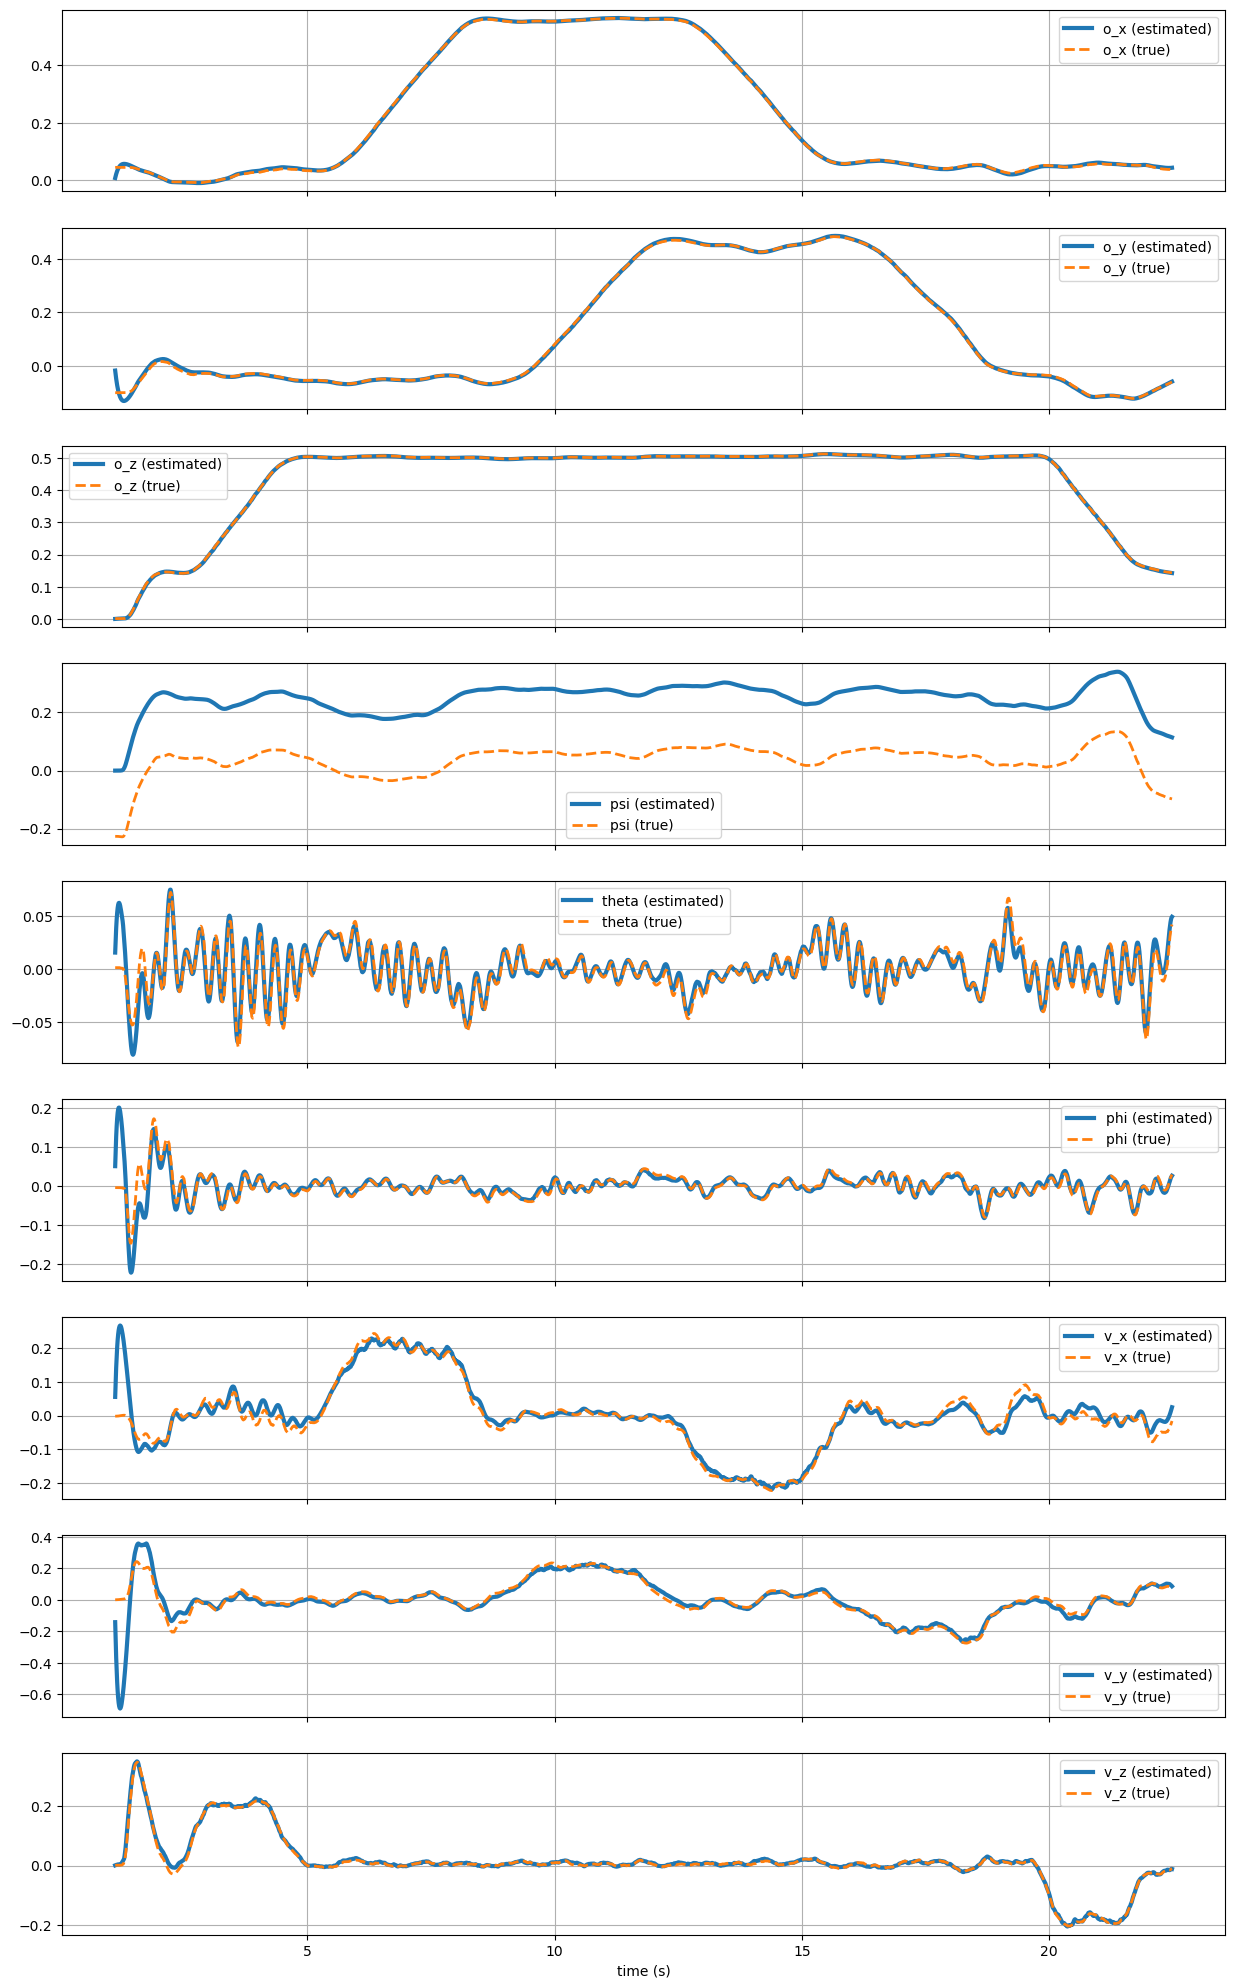

In [20]:
def comparison_plot(t, s_hat, s_true, name, ax):
    ax.plot(t, s_hat, label=f'{name} (estimated)', linewidth=3)
    ax.plot(t, s_true, '--', label=f'{name} (true)', linewidth=2)
    ax.legend()
    ax.grid()

fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True)
comparison_plot(t, o_x_hat, o_x_true, 'o_x', ax_o_x)
comparison_plot(t, o_y_hat, o_y_true, 'o_y', ax_o_y)
comparison_plot(t, o_z_hat, o_z_true, 'o_z', ax_o_z)
comparison_plot(t, psi_hat, psi_true, 'psi', ax_psi)
comparison_plot(t, theta_hat, theta_true, 'theta', ax_theta)
comparison_plot(t, phi_hat, phi_true, 'phi', ax_phi)
comparison_plot(t, v_x_hat, v_x_true, 'v_x', ax_v_x)
comparison_plot(t, v_y_hat, v_y_true, 'v_y', ax_v_y)
comparison_plot(t, v_z_hat, v_z_true, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')
plt.show()

Plot error in each state estimate with respect to ground truth.

In [21]:
# flight test data
# data = load_hardware_data('lab9_square_flight4.json', only_in_flight=False)
data = load_hardware_data('1206_custom_everything_hover1.json', only_in_flight=False)

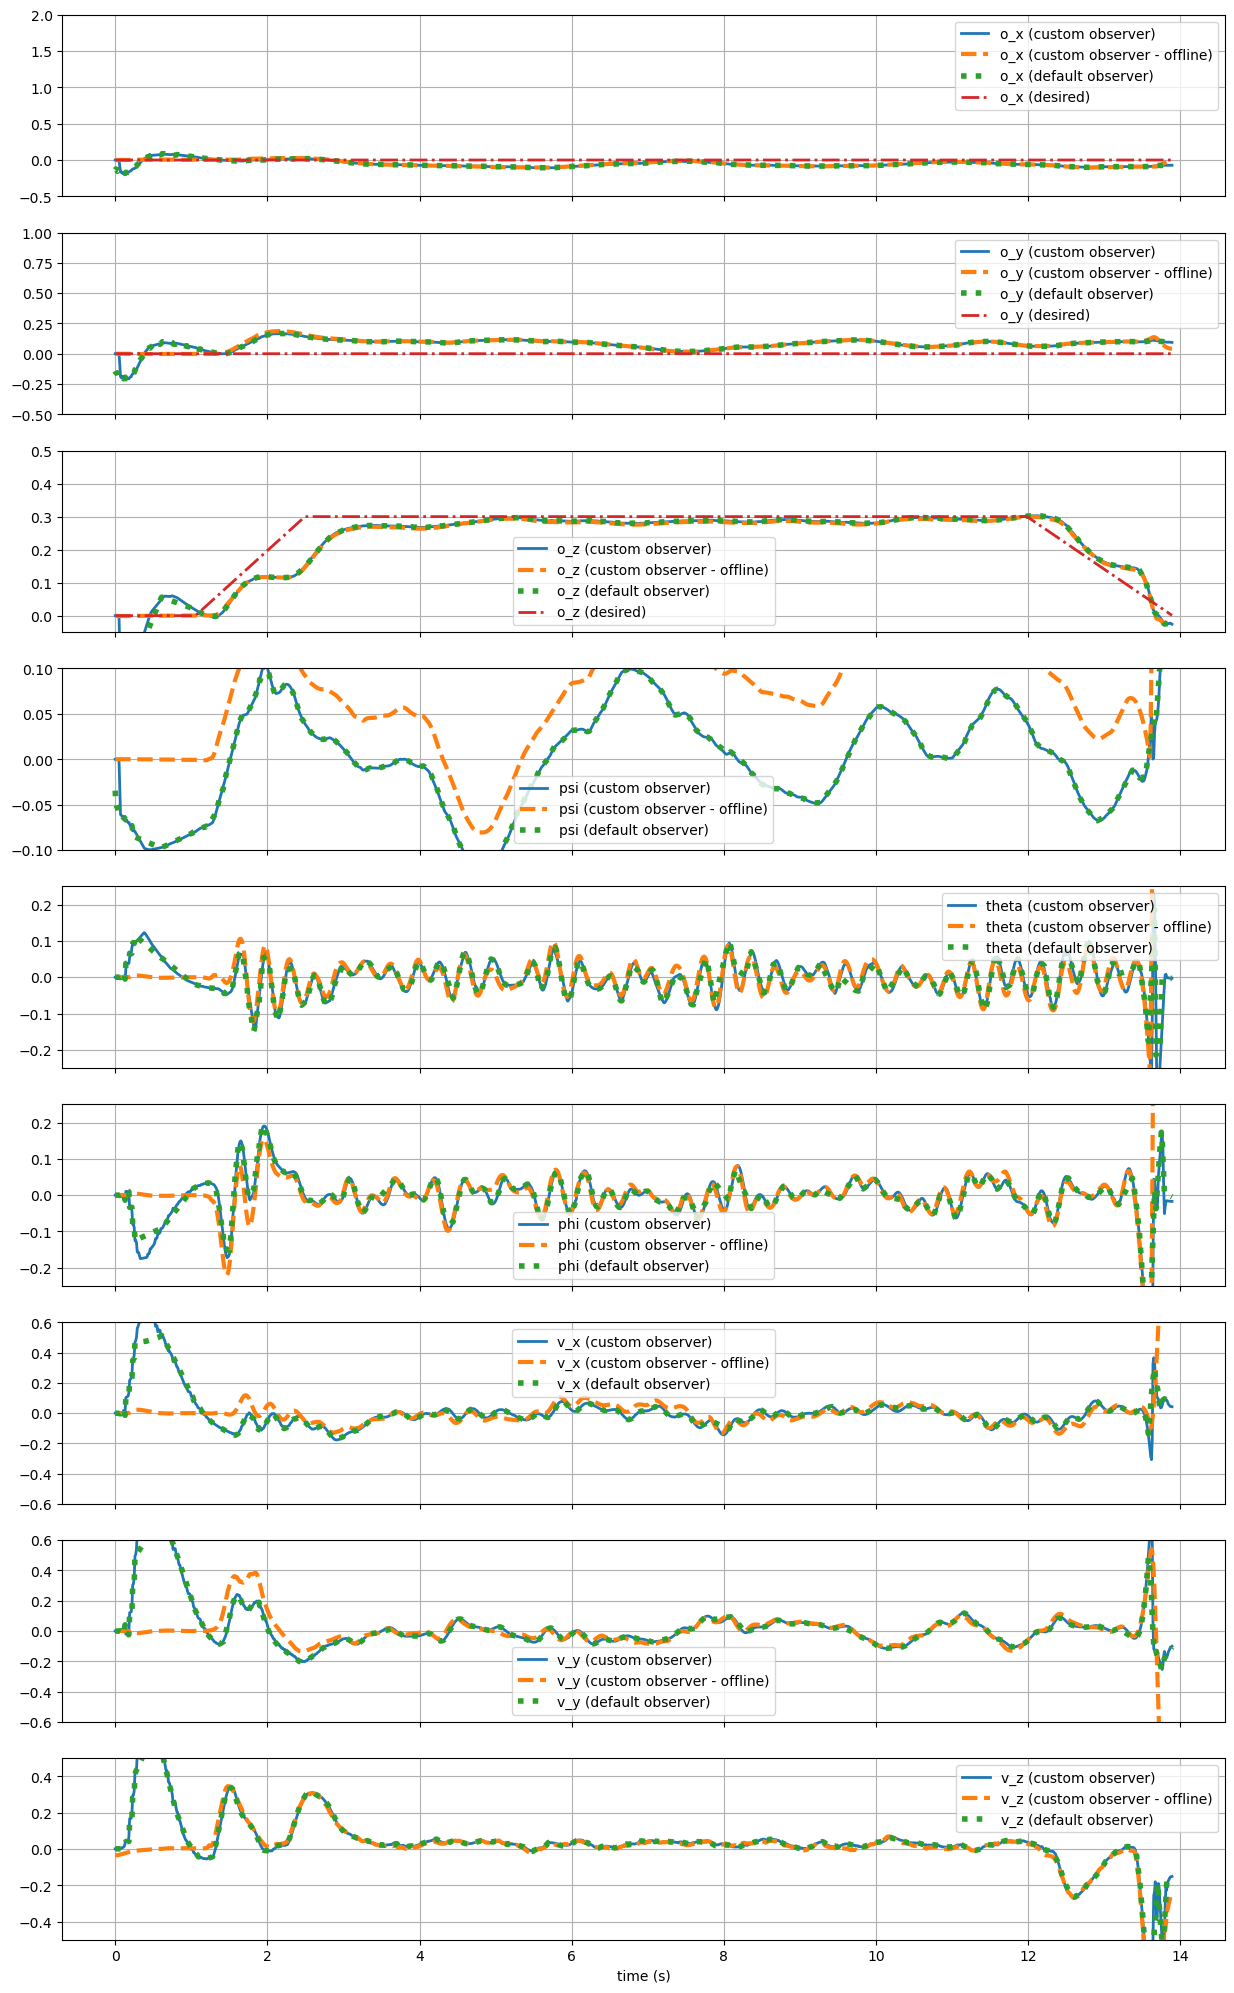

In [22]:
def comparison_plot(t, s_custom, s_default, s_offline, name, ax, s_des=None):
    ax.plot(t, s_custom, label=f'{name} (custom observer)', linewidth=2)
    ax.plot(t, s_offline, '--', label=f'{name} (custom observer - offline)', linewidth=3)
    ax.plot(t, s_default, ':', label=f'{name} (default observer)', linewidth=4)
    if s_des is not None:
        ax.plot(t, s_des, '-.', label=f'{name} (desired)', linewidth=2)
    ax.legend()
    ax.grid()

# time
t = data['time']

# state estimates from custom observer
o_x_custom = data['ae483log.o_x']
o_y_custom = data['ae483log.o_y']
o_z_custom = data['ae483log.o_z']
psi_custom = data['ae483log.psi']
theta_custom = data['ae483log.theta']
phi_custom = data['ae483log.phi']
v_x_custom = data['ae483log.v_x']
v_y_custom = data['ae483log.v_y']
v_z_custom = data['ae483log.v_z']

# state estimates from default observer
o_x_default = data['stateEstimate.x']
o_y_default = data['stateEstimate.y']
o_z_default = data['stateEstimate.z']
psi_default = np.deg2rad(data['stateEstimate.yaw'])
theta_default = - np.deg2rad(data['stateEstimate.pitch'])
phi_default = np.deg2rad(data['stateEstimate.roll'])
v_x_in0_default = data['stateEstimate.vx']
v_y_in0_default = data['stateEstimate.vy']
v_z_in0_default = data['stateEstimate.vz']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

# Create empty numpy arrays to hold the results
v_x_default = np.empty_like(v_x_in0_default)
v_y_default = np.empty_like(v_y_in0_default)
v_z_default = np.empty_like(v_z_in0_default)

# Apply coordinate transformation at each time step
for i in range(0, len(t)):
    # Get v in frame 0 at i'th time step from its components
    v_in0 = np.array([
        v_x_in0_default[i],
        v_y_in0_default[i],
        v_z_in0_default[i],
    ])
    
    # Get v in frame 1 at i'th time step by coordinate transformation
    v_in1 = R_1in0(psi_default[i], theta_default[i], phi_default[i]).T @ v_in0
    
    # Get components of v in frame 1 at i'th time step
    v_x_default[i] = v_in1[0]
    v_y_default[i] = v_in1[1]
    v_z_default[i] = v_in1[2]

# Define constants
g = 9.81
# k_flow = 4.09255568
o_z_eq = 0.5 # <-- FIXME: change equilibrium height
dt = 0.01

# Get inputs
w_x_offline = data['ae483log.w_x']
w_y_offline = data['ae483log.w_y']
w_z_offline = data['ae483log.w_z']
a_z_offline = data['ae483log.a_z']

# Get outputs
lh_x_offline = data['ae483log.lh_x']
lh_y_offline = data['ae483log.lh_y']
lh_z_offline = data['ae483log.lh_z']

# Initialize estimates
o_x = 0.
o_y = 0.
o_z = 0.
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.

# Initialize storage (do not change)
o_x_offline = np.zeros(len(t))
o_y_offline = np.zeros(len(t))
o_z_offline = np.zeros(len(t))
psi_offline = np.zeros(len(t))
theta_offline = np.zeros(len(t))
phi_offline = np.zeros(len(t))
v_x_offline = np.zeros(len(t))
v_y_offline = np.zeros(len(t))
v_z_offline = np.zeros(len(t))

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_offline[i]
    w_y = w_y_offline[i]
    w_z = w_z_offline[i]
    a_z = a_z_offline[i]
    lh_x = lh_x_offline[i]
    lh_y = lh_y_offline[i]
    lh_z = lh_z_offline[i]
    
    # Compute each element of: C x + D u - y
    lh_x_err = o_x - lh_x  # <-- FIXME
    lh_y_err = o_y - lh_y  # <-- FIXME
    lh_z_err = o_z - lh_z    # <-- FIXME
    
    # Update estimates
    o_x += dt * (-17.7581819124871*lh_x_err + 1.0*v_x)   # <-- FIXED
    o_y += dt * (-17.7223121570295*lh_y_err + 1.0*v_y)   # <-- FIXED
    o_z += dt * (-21.4301189917369*lh_z_err + 1.0*v_z)   # <-- FIXED
    psi += dt * (w_z)   # <-- FIXED
    theta += dt * (-34.3333333333332*lh_x_err + w_y) # <-- FIXED
    phi += dt * (50.7499999999999*lh_y_err + w_x)   # <-- FIXED
    v_x += dt * (-120.120956862936*lh_x_err + 9.81*theta)   # <-- FIXED
    v_y += dt * (-135.915174095598*lh_y_err - 9.81*phi)   # <-- FIXED
    v_z += dt * (a_z - g - 93.5000000000001*lh_z_err)   # <-- FIXED
    
    # Store estimates (do not change)
    o_x_offline[i] = o_x
    o_y_offline[i] = o_y
    o_z_offline[i] = o_z
    psi_offline[i] = psi
    theta_offline[i] = theta
    phi_offline[i] = phi
    v_x_offline[i] = v_x
    v_y_offline[i] = v_y
    v_z_offline[i] = v_z


fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True)

comparison_plot(t, o_x_custom, o_x_default, o_x_offline, 'o_x', ax_o_x, s_des=o_x_des)
comparison_plot(t, o_y_custom, o_y_default, o_y_offline, 'o_y', ax_o_y, s_des=o_y_des)
comparison_plot(t, o_z_custom, o_z_default, o_z_offline, 'o_z', ax_o_z, s_des=o_z_des)
comparison_plot(t, psi_custom, psi_default, psi_offline, 'psi', ax_psi)
comparison_plot(t, theta_custom, theta_default, theta_offline, 'theta', ax_theta)
comparison_plot(t, phi_custom, phi_default, phi_offline, 'phi', ax_phi)
comparison_plot(t, v_x_custom, v_x_default, v_x_offline, 'v_x', ax_v_x)
comparison_plot(t, v_y_custom, v_y_default, v_y_offline, 'v_y', ax_v_y)
comparison_plot(t, v_z_custom, v_z_default, v_z_offline, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')

ax_o_x.set_ylim([-0.5, 2])
ax_o_y.set_ylim([-0.5, 1])
ax_o_z.set_ylim([-0.05, 0.5])
ax_psi.set_ylim([-0.1, 0.1])
ax_theta.set_ylim([-0.25, 0.25])
ax_phi.set_ylim([-0.25, 0.25])
ax_v_x.set_ylim([-0.6, 0.6])
ax_v_y.set_ylim([-0.6, 0.6])
ax_v_z.set_ylim([-0.5, 0.5])

plt.show()

**How come the offline and custom psi graphs don't match? (see for yourself on `lab9_square_flight4.json`)**

We believe it's because the drone had a little bit of initial yaw to begin with. The drone wasn't perfectly aligned to the global reference axes when taking off. But the offline observer assumes that while the custom observer "learns" this fact during takeoff and starts off with a non-zero yaw. 

However, looking at the three lines below makes it clear that the initial yaw error is the only thing that's wrong. The peaks and valleys and the changes in the yaw seen by default and offline match each other. 

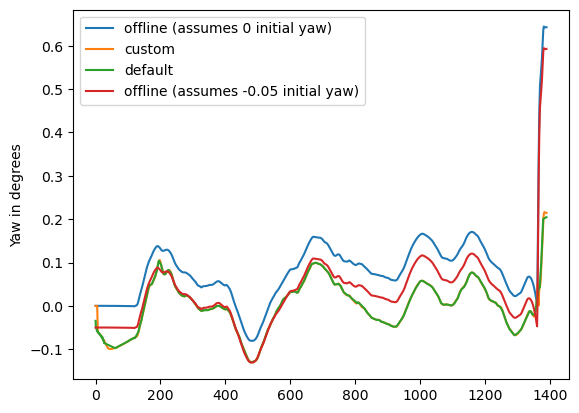

In [25]:
initial_offset = -0.05
plt.plot(psi_offline, label = 'offline (assumes 0 initial yaw)')
plt.plot(psi_custom, label ='custom')
plt.plot(psi_default, label = 'default')
plt.plot(psi_offline + initial_offset, label = 'offline (assumes '+str(initial_offset) +' initial yaw)')
plt.ylabel('Yaw in degrees')
plt.legend()

## 3.5 Summary and discussion

The following table reports the RMSE in each state estimate:

|  | $o_x$ | $o_y$ | $o_z$ | $\psi$ | $\theta$ | $\phi$ | $v_x$ | $v_y$ | $v_z$ |
| --: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| RMSE with equal weights | 0.001 | 0.002 | 0.003 | 0.004 | 0.005 | 0.006 | 0.007 | 0.008 | 0.009 |
| RMSE with weights from error model variance | 0.001 | 0.002 | 0.003 | 0.004 | 0.005 | 0.006 | 0.007 | 0.008 | 0.009 |

**Modify the text in this cell** to answer the following questions:

* Which observer performs better, the one derived from equal weights or the one derive from weights based on error model variance? Why? (Make reference to your table of results when answering this question.)
* Is there a difference in what happens to the error in your estimate of (1) observable states and (2) non-observable states over time? Why? (Make reference to your plots when answering this question.)
* We refer to the state estimates that are computed on-board by the default code as "true"? Are they? For example, compare the landing position that you measured with a ruler (Section 3.1) to the final position that was estimated by the default code - to what extent are they the same? (You may want to disinguish between observable and non-observable states when answering this question.)

# 4. Flight test while moving in squares

**Drone was flown using custom controller and observer.**

Load and parse flight test data.

In [35]:
# flight test data
data = load_hardware_data('lab9_square_flight4.json', only_in_flight=True)

# times
t = data['time']

# position and orientation from default observer
o_x_default = data['stateEstimate.x']
o_y_default = data['stateEstimate.y']
o_z_default = data['stateEstimate.z']
psi_default = np.deg2rad(data['stateEstimate.yaw'])
theta_default = -np.deg2rad(data['stateEstimate.pitch'])
phi_default = np.deg2rad(data['stateEstimate.roll'])

# position and orientation from custom observer
o_x_custom = data['ae483log.o_x']
o_y_custom = data['ae483log.o_y']
o_z_custom = data['ae483log.o_z']
psi_custom = data['ae483log.psi']
theta_custom = data['ae483log.theta']
phi_custom = data['ae483log.phi']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

Plot position, desired position, and orientation (both from default and custom observer) **over the entire flight test**.

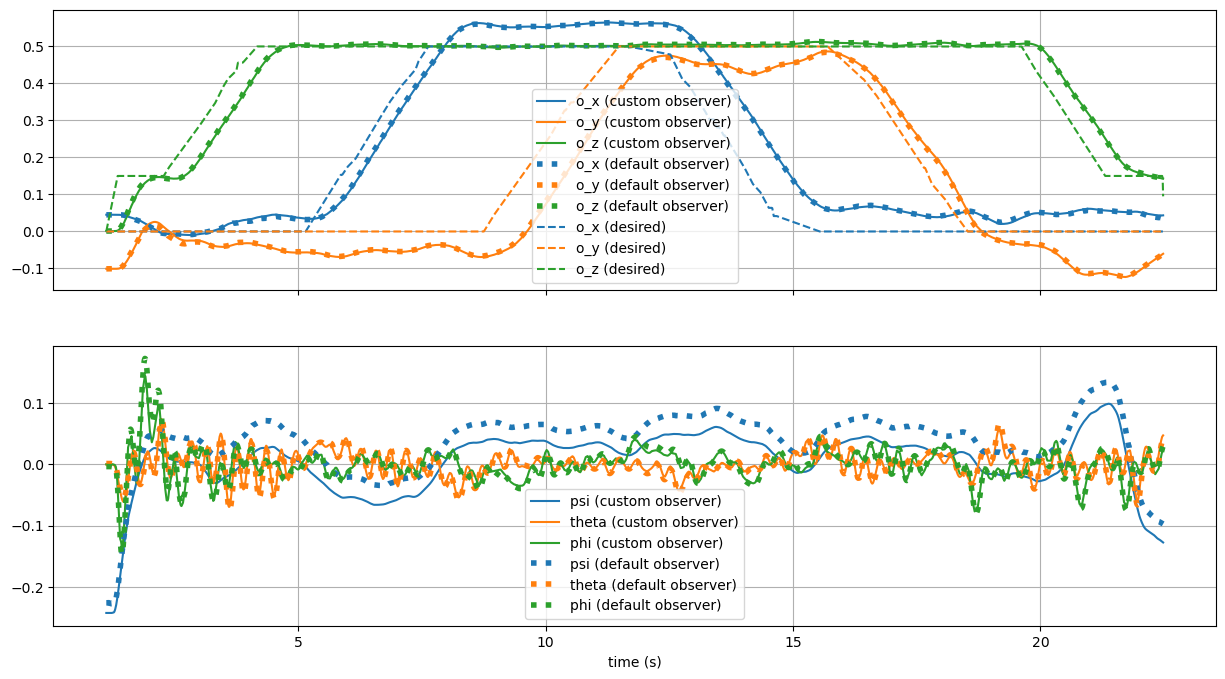

In [36]:
fig, (ax_pos, ax_ori) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
px = ax_pos.plot(t, o_x_custom, label=f'o_x (custom observer)')
py = ax_pos.plot(t, o_y_custom, label=f'o_y (custom observer)')
pz = ax_pos.plot(t, o_z_custom, label=f'o_z (custom observer)')
ax_pos.plot(t, o_x_default, ':', label=f'o_x (default observer)', color=px[0].get_color(), linewidth=4)
ax_pos.plot(t, o_y_default, ':', label=f'o_y (default observer)', color=py[0].get_color(), linewidth=4)
ax_pos.plot(t, o_z_default, ':', label=f'o_z (default observer)', color=pz[0].get_color(), linewidth=4)
ax_pos.plot(t, o_x_des, '--', label=f'o_x (desired)', color=px[0].get_color())
ax_pos.plot(t, o_y_des, '--', label=f'o_y (desired)', color=py[0].get_color())
ax_pos.plot(t, o_z_des, '--', label=f'o_z (desired)', color=pz[0].get_color())
ax_pos.legend()
ax_pos.grid()
ppsi = ax_ori.plot(t, psi_custom, label=f'psi (custom observer)')
ptheta = ax_ori.plot(t, theta_custom, label=f'theta (custom observer)')
pphi = ax_ori.plot(t, phi_custom, label=f'phi (custom observer)')
ax_ori.plot(t, psi_default, ':', label=f'psi (default observer)', color=ppsi[0].get_color(), linewidth=4)
ax_ori.plot(t, theta_default, ':', label=f'theta (default observer)', color=ptheta[0].get_color(), linewidth=4)
ax_ori.plot(t, phi_default, ':', label=f'phi (default observer)', color=pphi[0].get_color(), linewidth=4)
ax_ori.legend()
ax_ori.grid()
ax_ori.set_xlabel('time (s)')
plt.show()

Plot top-down position and desired position (both from default and custom observer).

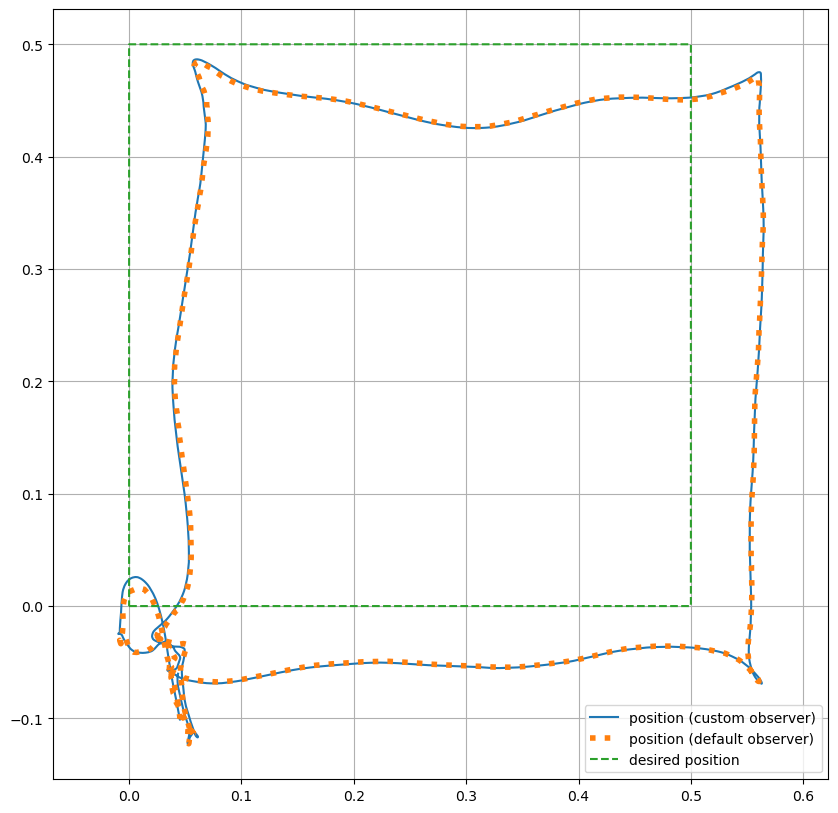

In [37]:
plt.figure(figsize=(10, 10))
plt.plot(o_x_custom, o_y_custom, label='position (custom observer)')
plt.plot(o_x_default, o_y_default, ':', label='position (default observer)', linewidth=4)
plt.plot(o_x_des, o_y_des, '--', label='desired position')
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

**FIXME: REPLACE THIS CELL WITH A DISCUSSION OF RESULTS.**

First, fill in the following table:

| | $o_x$ (meters) | $o_y$ (meters) |
| ---: | :---: | :---: |
| landing position (measured by ruler) | 0.000 | 0.000 |
| landing position (from custom observer) | 0.000 | 0.000 |
| landing position (from default observer) | 0.000 | 0.000 |

Then, answer the following questions:

* Last week, you may have noticed that position estimates from the default observer appeared "good" and position estimates from the custom observer appeared "bad". This week, you may have noticed the opposite. What is going on here? Which state estimates are correct? (Are *any* of them correct?) Like last week, you will want to compare the landing position that you measured with a ruler to the final position that was estimated by each observer, and will also want to think about which states are observable (and about what that means).
* To what extent does your code enable the drone to track a desired position? It may help to look at the top-down plot when answering this question. Are there ways you could improve tracking performance?